
# Analiza meteoroloških podatkov (vir : ARSO)
## Uvoz podatkov

Podatki so že prej bili naloženi s programoma <TT>prenos-identifikatorjev.py</TT> in <TT>podatki-posameznih-postaj.py</TT>

Datoteka <TT>slovar.csv</TT> vsebuje povezavo med imenom postaje in njenim identifikatorjem. 

V <i>/postaje/</i> so datoteke s podatki posameznih postaj po imenih <TT>HXXXX_t_30.html.csv</TT>, kjer XXXX predstavlja identifikacijsko številko postaje.

In [26]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [27]:
slovar=[*csv.DictReader(open('slovar.csv'))] #odprem in shranim slovar od prej kot slovar tukaj

In [15]:
def spremeni_v_int(seznam):
    """
    Funkcija, ki sprejme 2 dimenzionalen seznam (n,4) [datum, višina, pretok, temperatura] in vrne številčni 2d array [višina, pretok]

    Vsak "-" v drugem in tretjem stolpcu spremeni v -1, da lahko potem s seznamom upravljamo kot s števili
    """
    for indeks, i in enumerate(seznam):
        for jndeks, j in enumerate(i):
            if j=='-':
                seznam[indeks, jndeks]="-1"
    print(list(np.asfarray(seznam[1])))
    novseznam = np.array([np.asfarray(seznam[1]), np.asfarray(seznam[2])])
    
                
    #seznam[1::, 1] = np.asfarray(seznam[1::, 1]) ni hotelo delati iz nekega razloga, zato grem na loope
    #seznam[1::, 2] = np.asfarray(seznam[1::, 2])
    #seznam[1::, 3] = np.asfarray(seznam[1::, 3])

    return novseznam 

In [16]:
id = slovar[2]["ID"]

arr = np.loadtxt("postaje/" + id + ".csv",
                 delimiter=",", dtype=str)

arr = np.transpose(np.delete(arr, 0, 0))
display(arr[1])

array(['78', '78', '78', ..., '79', '79', '79'], dtype='<U24')

In [17]:
arr = spremeni_v_int(arr)
arr

[78.0, 78.0, 78.0, 79.0, 78.0, 79.0, 79.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 81.0, 80.0, 80.0, 80.0, 80.0, 81.0, 81.0, 80.0, 80.0, 81.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 79.0, 80.0, 79.0, 79.0, 79.0, 80.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 82.0, 81.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 81.0, 82.0, 81.0, 81.0, 81.0, 81.0, 81.0, 80.0, 80.0, 80.0, 80.0, 80.0, 81.0, 81.0, 81.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 82.0, 82.0, 82.0, 83.0, 82.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 81.0, 82.0, 82.0, 82.0, 82.0, 82.0, 81.0, 81.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.

array([[7.8e+01, 7.8e+01, 7.8e+01, ..., 7.9e+01, 7.9e+01, 7.9e+01],
       [3.0e-02, 3.0e-02, 3.0e-02, ..., 3.6e-02, 3.6e-02, 3.6e-02]])

In [18]:
order = np.argsort(arr[1::,1])
xs = np.array(arr[1::,1])[order][100:120]
ys = np.array(arr[1::,2])[order]
xs


array([], dtype=float64)

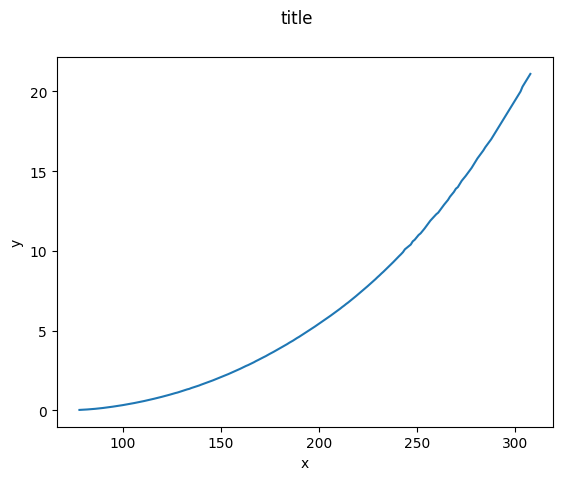

In [19]:
order = np.argsort(arr[0])
xs = np.array(arr[0])[order]
ys = np.array(arr[1])[order]

fig = plt.figure()
ax = plt.subplot()

fig.suptitle('title')
plt.xlabel('x')
plt.ylabel('y')

ax.plot(xs, ys, label='desc' )
plt.show()

[ 4.05242620e-04 -6.82182355e-02  2.99325706e+00]


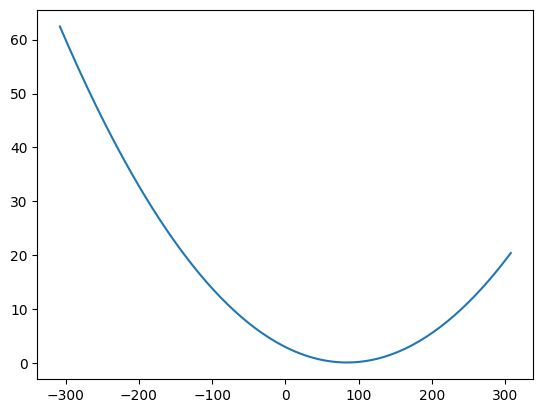

In [20]:
fit = np.poly1d(np.polyfit(xs, ys, 2))
print(np.polyfit(xs, ys, 2))
x = np.linspace(-xs[-1], xs[-1], 200)
plt.plot(x, fit(x))

In [21]:
np.asfarray(arr[1::, 1]).copy()

array([0.03])

In [22]:
arr[1::, 1]

array([0.03])

In [28]:
slovar

[{'Ime': 'Gornja Radgona I', 'Reka': 'Mura', 'ID': 'H1060_t_30.html'},
 {'Ime': 'Petanjci', 'Reka': 'Mura', 'ID': 'H1070_t_30.html'},
 {'Ime': 'Cankova', 'Reka': 'Kučnica', 'ID': 'H1100_t_30.html'},
 {'Ime': 'Pristava', 'Reka': 'Ščavnica', 'ID': 'H1140_t_30.html'},
 {'Ime': 'Nuskova', 'Reka': 'Ledava', 'ID': 'H1165_t_30.html'},
 {'Ime': 'Polana I', 'Reka': 'Ledava', 'ID': 'H1220_t_30.html'},
 {'Ime': 'Čentiba', 'Reka': 'Ledava', 'ID': 'H1260_t_30.html'},
 {'Ime': 'Martjanci', 'Reka': 'Martjanski potok', 'ID': 'H1300_t_30.html'},
 {'Ime': 'Kobilje I', 'Reka': 'Kobiljski potok', 'ID': 'H1312_t_30.html'},
 {'Ime': 'Središče', 'Reka': 'Ivanjševski potok', 'ID': 'H1335_t_30.html'},
 {'Ime': 'Hodoš I', 'Reka': 'Velika Krka', 'ID': 'H1355_t_30.html'},
 {'Ime': 'Črneče', 'Reka': 'Drava', 'ID': 'H2005_t_30.html'},
 {'Ime': 'Ptuj', 'Reka': 'Drava', 'ID': 'H2110_t_30.html'},
 {'Ime': 'Borl I', 'Reka': 'Drava', 'ID': 'H2150_t_30.html'},
 {'Ime': 'Zavrč', 'Reka': 'Drava', 'ID': 'H2160_t_30.html'},
